In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

In [3]:
NUM_SAMPLES = 5000

DS = Path("../../datasets/")
BASE_DS_DIR = DS / "T004-taco-crops"

In [80]:
import json

def _is_numeric_dir(d):
    try:
        int(d.name)
        return True
    except:
        return False


def _dict_to_markdown_table(d):
    keys = list(d.keys())
    vals = list(d.values())

    max_key = max(len(str(k)) for k in keys + ["Key"])
    max_val = max(len(str(v)) for v in vals + ["Value"])

    lines = []
    lines.append(f"| {'Key'.ljust(max_key)} | {'Value'.ljust(max_val)} |")
    lines.append(f"|{'-' * (max_key + 2)}|{'-' * (max_val + 2)}|")

    for k, v in d.items():
        lines.append(f"| {str(k).ljust(max_key)} | {str(v).ljust(max_val)} |")

    return "\n".join(lines)

class DumpedDir:
    def __init__(self, d: Path, params: dict):
        self.d = d
        self.params = params

    def dump_params(self):
        with open(self.d / "params.json", "w") as f:
            json.dump(self.params, f)

    @classmethod
    def export_pkl(self):
        return self.d / "log" / "export.pkl"

    @property
    def history(self):
        return self.d / "log" / "history.csv"

    @property
    def readme(self):
        return self.d / "README.md"

    @property
    def result_png(self):
        return self.d / "res.png"

    @classmethod
    def parse_markdown(cls, d: Path):
        mkd = d / "README.md"
        if not mkd.exists():
            return None
        with open(mkd) as f:
            params, _ = parse_markdown_params_and_history(f.read())
        return cls(d, params)
    
    @classmethod
    def from_params(cls, d: Path):
        params = d / "params.json"
        if not params.exists():
            raise Exception(f"params not found {params}")
        with open(params) as f:
            params = json.load(f)
        return cls(d, params)
    
    def show(self, only_png=False):
        if not only_png:
            with open(self.readme) as f:
                print(f.read())
        plt.imshow(plt.imread(self.result_png))
        plt.show()
        return self
        

def parse_markdown_params_and_history(md):
    def parse_table(lines):
        header = [h.strip() for h in lines[0].strip("|").split("|")]
        rows = []
        for line in lines[2:]:  # skip header + separator
            vals = [v.strip() for v in line.strip("|").split("|")]
            rows.append(dict(zip(header, vals)))
        return rows

    lines = [l.rstrip() for l in md.splitlines()]
    tables = []
    current = []

    for line in lines:
        if line.startswith("|"):
            current.append(line)
        else:
            if current:
                tables.append(current)
                current = []
    if current:
        tables.append(current)

    params_rows = parse_table(tables[0])
    history_rows = parse_table(tables[1])

    params = {row["Key"]: row["Value"] for row in params_rows}

    return params, history_rows

class Dumps:
    def __init__(self, dumps: list[DumpedDir]):
        self.dumps = dumps

    def show_idx(self, idx, only_png=False):
        d = self.dumps[idx]
        return d.show(only_png=only_png)
    
    def find_with_params(self, params):
        for d in self.dumps:
            if params == d.params:
                return d
        return None

    def show_with_different(self, base_idx, changes=None, make_change=True, only_png=False):
        # given a base dump we use its params as base
        # we apply the changes and show the new dump if present
        base = self.dumps[base_idx]
        if not changes:
            return base.show(only_png)
        if not make_change:
            return base.show(only_png)
        new_params = {
            **base.params,
            **changes,
        }
        d = self.find_with_params(new_params)
        if d:
            return d.show(only_png=only_png)
        else:
            print("not found with params")
            print(_dict_to_markdown_table(new_params))

In [81]:
dumps = BASE_DS_DIR.glob("*")
dumps = filter(Path.is_dir, dumps)
dumps = filter(_is_numeric_dir, dumps)
dumps = filter(lambda d: (d/"params.json").exists(), dumps)
dumps = map(DumpedDir.from_params, dumps)
dumps = list(dumps)

In [82]:
man = Dumps(dumps)


# Params

| Key                  | Value              |
|----------------------|--------------------|
| FINE_TUNE_EPOCHS     | 10                 |
| FIT_ONE_CYCLE_EPOCHS | 5                  |
| MODEL                | mobilenet_v3_small |
| NUM_SAMPLES          | 5000               |
| FILE_SIZE            | 50                 |
| LOSS                 | ELSE               |
| retries              | 0                  |

---

# History

| epoch | train_loss          | valid_loss          | time  |
| ----- | ------------------- | ------------------- | ----- |
| 0     | 0.2975115180015564  | 0.2186482697725296  | 00:14 |
| 1     | 0.29696014523506165 | 0.21679739654064178 | 00:14 |
| 2     | 0.3026735186576843  | 0.2153058648109436  | 00:14 |
| 3     | 0.30425897240638733 | 0.2166174054145813  | 00:14 |
| 4     | 0.30304089188575745 | 0.21667054295539856 | 00:14 |

---


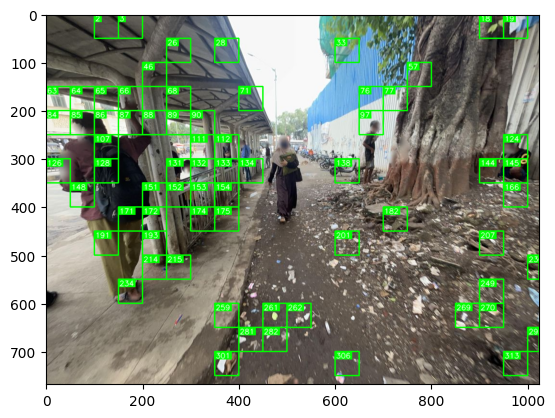

In [ ]:
man.show_with_different(0, make_change=False, changes={"MODEL": "mobilenet_v3_large"}, only_png=False)

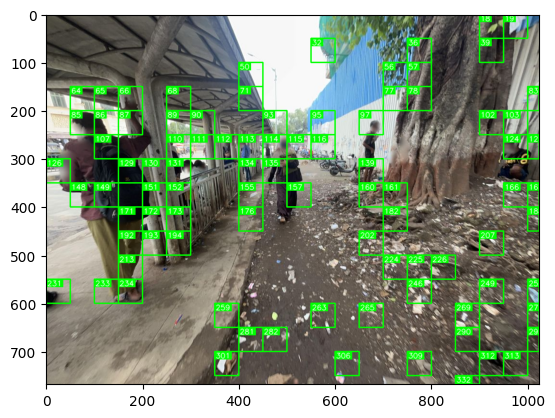

In [105]:
man.show_with_different(0, make_change=True, changes={"FILE_SIZE": "25", "LOSS": "CrossEntropyLossFlat"}, only_png=True)

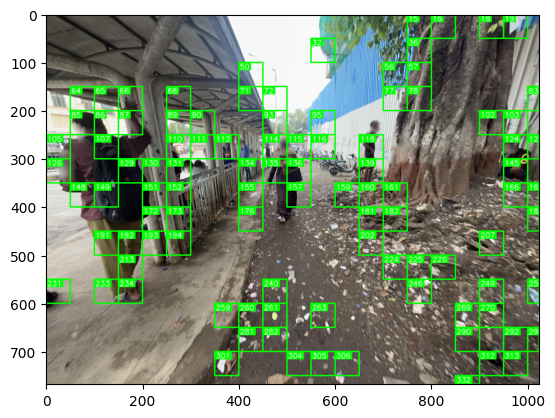

In [106]:
man.show_with_different(0, make_change=True, changes={"FILE_SIZE": "25", "LOSS": "ELSE"}, only_png=True)

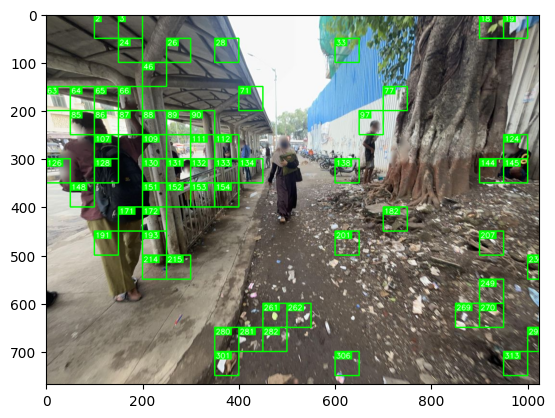

In [92]:
man.show_with_different(0, make_change=True, changes={"MODEL": "mobilenet_v3_large", "NUM_SAMPLES": "10000"}, only_png=True)

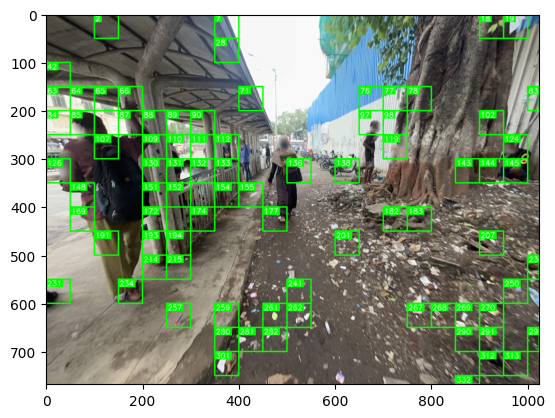

In [93]:
man.show_with_different(0, make_change=True, changes={"MODEL": "mobilenet_v3_large"}, only_png=True)


# Params

| Key                  | Value                |
|----------------------|----------------------|
| FINE_TUNE_EPOCHS     | 10                   |
| FIT_ONE_CYCLE_EPOCHS | 10                   |
| MODEL                | mobilenet_v3_large   |
| NUM_SAMPLES          | 2000                 |
| FILE_SIZE            | 35                   |
| LOSS                 | CrossEntropyLossFlat |
| retries              | 0                    |

---

# History

| epoch | train_loss          | valid_loss          | time  |
| ----- | ------------------- | ------------------- | ----- |
| 0     | 0.3383246064186096  | 0.2435167133808136  | 00:13 |
| 1     | 0.35328686237335205 | 0.23981676995754242 | 00:13 |
| 2     | 0.34252649545669556 | 0.2386574149131775  | 00:13 |
| 3     | 0.32688242197036743 | 0.2376750111579895  | 00:13 |
| 4     | 0.33514368534088135 | 0.23701360821723938 | 00:13 |
| 5     | 0.33435946702957153 | 0.23632468283176422 | 00:13 |
| 6     | 0.3260989189147949  | 0.2364338785

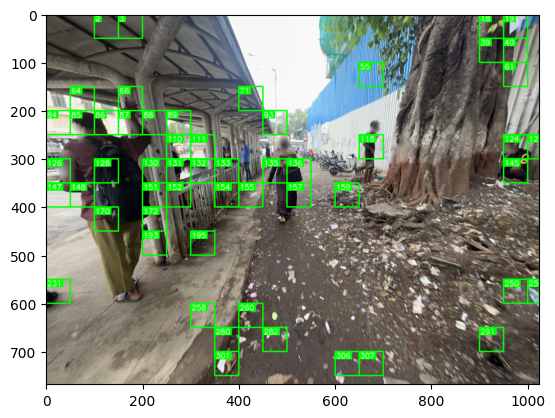

In [58]:
_ = man.show_with_different(1)
# man.show_idx(1)